In [32]:
import pandas as pd
import numpy as np

# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# 선형회귀분석 모델
import statsmodels.formula.api as smf
# 회귀분석의 정규성 확인: qqplot, add_constant
from statsmodels.api import qqplot, add_constant
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 학습용/평가용 데이터 분리: train/test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# 선형회귀모형
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가 함수
from sklearn.metrics import r2_score
# 선형 모델
from sklearn.linear_model import Ridge, Lasso, ElasticNet


# 평가 함수
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


# export_graphviz: 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 예측/회귀 Decision Tree
from sklearn.tree import DecisionTreeRegressor
# 예측/회귀 Random Forest
from sklearn.ensemble import RandomForestRegressor
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 예측/회귀 Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline



In [34]:
# 기본 라이브러리
import pandas as pd
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 깨짐 방지 (Mac용)
import matplotlib
matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
df = pd.read_csv('./df_clean.csv', parse_dates=['OrderDT', 'DeliveryDT'])


# 확인
print("✅ 데이터 shape:", df.shape)
print("✅ 컬럼 목록:\n", df.columns)
df.head()


✅ 데이터 shape: (856727, 32)
✅ 컬럼 목록:
 Index(['idUser', 'Gender', 'Age', 'AgeGroup', 'FamilyCount', 'MemberYN',
       'idOrder', 'OrderDT', 'OrderMonth', 'OrderDay', 'OrderHour',
       'OrderMinute', 'OrderSecond', 'ItemCode', 'ItemLargeName',
       'ItemMiddleName', 'ItemSmallName', 'ItemName', 'Price', 'PriceYear',
       'PriceMin', 'PriceMax', 'DeliveryDT', 'Deli_Year', 'Deli_Month',
       'Deli_Day', 'Deli_Hour', 'Deli_Minute', 'Deli_Second', 'Deli_Duration',
       'Deli_Hours', 'IsMorningDelivery'],
      dtype='object')


,idUser,Gender,Age,AgeGroup,FamilyCount,MemberYN,idOrder,OrderDT,OrderMonth,OrderDay,...,DeliveryDT,Deli_Year,Deli_Month,Deli_Day,Deli_Hour,Deli_Minute,Deli_Second,Deli_Duration,Deli_Hours,IsMorningDelivery
0,U10001,여성,26,20대,2,Y,U10001-O2022-1002,2022-01-06 17:08:00,1,6,...,2022-01-07 06:24:00,2022,1,7,6,24,0,0 days 13:16:00,13.266667,1
1,U10001,여성,26,20대,2,Y,U10001-O2022-1002,2022-01-06 17:08:00,1,6,...,2022-01-07 06:24:00,2022,1,7,6,24,0,0 days 13:16:00,13.266667,1
2,U10001,여성,26,20대,2,Y,U10001-O2022-1002,2022-01-06 17:08:00,1,6,...,2022-01-07 06:24:00,2022,1,7,6,24,0,0 days 13:16:00,13.266667,1
3,U10001,여성,26,20대,2,Y,U10001-O2022-1002,2022-01-06 17:08:00,1,6,...,2022-01-07 06:24:00,2022,1,7,6,24,0,0 days 13:16:00,13.266667,1
4,U10001,여성,26,20대,2,Y,U10001-O2022-1003,2022-01-13 16:50:00,1,13,...,2022-01-14 06:28:00,2022,1,14,6,28,0,0 days 13:38:00,13.633333,1


## 과일 내 소분류 (구매건수) 높은 순 - 한 주문을 한 장바구니로

### 분석 기준: (idUser, OrderDT) → 하나의 장바구니

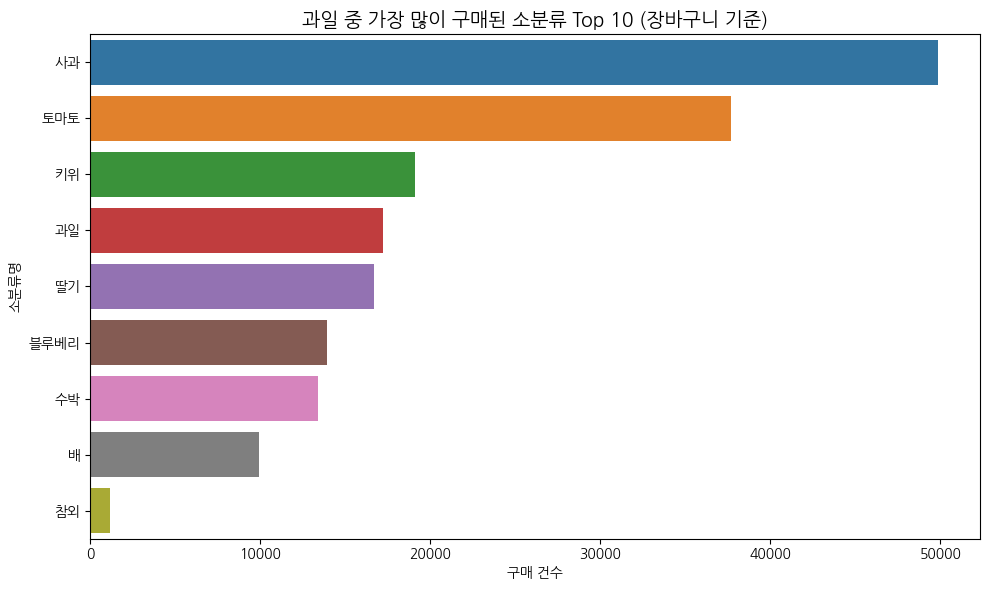

In [36]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 파일 경로
file_path = "./df_clean.csv"

# 데이터 불러오기
df_clean = pd.read_csv(file_path)

# Step 1: idUser + OrderDT로 장바구니 묶기
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# Step 2: '과일'이 포함된 중분류(ItemMiddleName) 필터링
fruit_df = df_clean[df_clean['ItemMiddleName'] == '과일']

# Step 3: 과일 관련 주문건의 소분류(ItemSmallName) 건수 집계
fruit_counts = (
    fruit_df.groupby(['idUser', 'OrderDT'])['ItemSmallName']
    .apply(list)
    .explode()
    .value_counts()
    .reset_index()
)
fruit_counts.columns = ['ItemSmallName', 'PurchaseCount']

# Step 4: 상위 10개만 시각화
top_fruit_counts = fruit_counts.head(10)

# Step 5: 그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=top_fruit_counts, y='ItemSmallName', x='PurchaseCount')
plt.title('과일 중 가장 많이 구매된 소분류 Top 10 (장바구니 기준)', fontsize=14)
plt.xlabel('구매 건수')
plt.ylabel('소분류명')
plt.tight_layout()
plt.show()


# '과일', '수산', ' 채소' 중 주문 높은 순

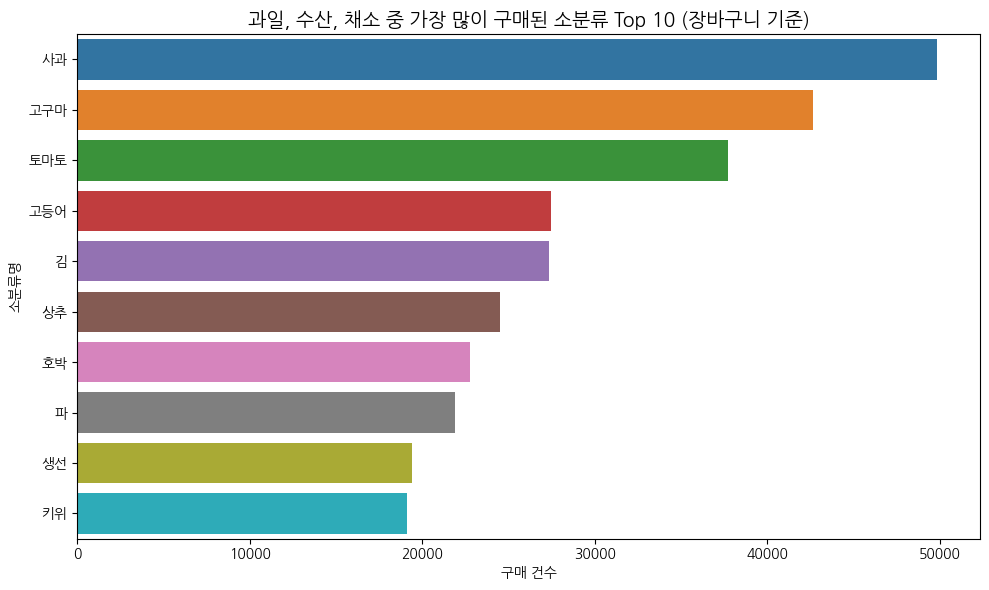

In [37]:
# 실행 상태 초기화로 인한 파일 재불러오기 및 분석 재실행

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 파일 경로
file_path = "./df_clean.csv"

# 데이터 불러오기
df_clean = pd.read_csv(file_path)

# 날짜형 변환
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# '과일', '수산', '채소' 중분류 필터링
filtered_df = df_clean[df_clean['ItemMiddleName'].isin(['과일', '수산', '채소'])]

# 장바구니 단위로 소분류 집계
item_counts = (
    filtered_df.groupby(['idUser', 'OrderDT'])['ItemSmallName']
    .apply(list)
    .explode()
    .value_counts()
    .reset_index()
)
item_counts.columns = ['ItemSmallName', 'PurchaseCount']

# 상위 10개 추출
top_item_counts = item_counts.head(10)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=top_item_counts, y='ItemSmallName', x='PurchaseCount')
plt.title('과일, 수산, 채소 중 가장 많이 구매된 소분류 Top 10 (장바구니 기준)', fontsize=14)
plt.xlabel('구매 건수')
plt.ylabel('소분류명')
plt.tight_layout()
plt.show()


# '사과' 구매 기준 연관분석 (주문 건 단위 기준)

In [38]:
# 1. 필요한 라이브러리 설치 및 불러오기
# pip install mlxtend (처음 한 번만 설치)
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# 2. 데이터 불러오기
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 3. 주문 건 단위로 장바구니 묶기
basket = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 4. '사과'가 포함된 장바구니만 필터링
basket_with_apple = basket[basket.apply(lambda x: '사과' in x)]

# 5. One-hot encoding
te = TransactionEncoder()
te_ary = te.fit(basket_with_apple).transform(basket_with_apple)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 6. Apriori 알고리즘 적용
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)


# 7. 연관 규칙 추출 및 '사과'가 antecedents에 포함된 것만 필터링
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules_with_apple = rules[rules['antecedents'].apply(lambda x: '사과' in x)]

# 8. lift 기준으로 내림차순 정렬 + 상위 10개 추출
rules_by_lift = rules_with_apple.sort_values(by='lift', ascending=False).head(10)

# 9. 주요 열 출력
print(rules_by_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


        antecedents consequents   support  confidence      lift
1488       (키위, 사과)        (멸치)  0.005698    0.066077  1.205256
1490       (사과, 멸치)        (키위)  0.005698    0.103928  1.205256
2232  (사과, 김치, 토마토)        (냉동)  0.007358    0.379191  1.158916
2235       (사과, 냉동)   (김치, 토마토)  0.007358    0.022487  1.158916
1050       (사과, 냉동)        (깻잎)  0.005272    0.016111  1.158431
1048       (깻잎, 사과)        (냉동)  0.005272    0.379032  1.158431
2214   (사과, 생선, 냉동)        (김치)  0.005675    0.180071  1.153858
2216       (사과, 김치)    (생선, 냉동)  0.005675    0.036366  1.153858
508       (드레싱, 사과)       (고구마)  0.009354    0.216174  1.151629
507       (고구마, 사과)       (드레싱)  0.009354    0.049833  1.151629


### 왜 lift 기준인가?
1. Confidence는 "조건부 확률"일 뿐  
예를 들어 사과 → 바나나에서 confidence가 0.8이라고 해보자.
→ 이건 사과를 산 사람 중 80%가 바나나도 샀다는 뜻이야.

✅ 하지만 바나나 자체가 모든 고객이 자주 사는 제품이면?
→ 사과 없이도 바나나는 잘 팔리는 거야. 이건 우연한 동시 구매일 수 있어.

2. Support만으로는 연관이 높다고 말할 수 없는 이유
🔹 1. 그냥 자주 팔리는 것일 수 있음
예를 들어 사과랑 바나나가 자주 같이 팔린다고 해보자.
→ 그건 둘 다 인기 상품이라서일 수도 있어.
→ 즉, 서로의 영향은 없고, 그냥 동시에 잘 팔리는 우연일 수도 있어.

자주 팔린다고 해서 원인-결과 관계가 있는 건 아니지.


# 사과만 샀을때 

In [39]:
# 1. 필요한 라이브러리
# pip install mlxtend (처음 한 번만 설치)
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 2. 데이터 불러오기 및 전처리
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 3. 주문 건 단위 장바구니 생성
basket = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 4. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 5. Apriori 알고리즘
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

# 6. 연관규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 7. 사과만 antecedents로 갖는 규칙 필터링
rules_just_apple = rules[rules['antecedents'] == frozenset({'사과'})]

# 8. lift 기준 Top 10 정렬
top10_rules = rules_just_apple.sort_values(by='lift', ascending=False).head(10)

# 9. 결과 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

    antecedents consequents   support  confidence      lift
573        (사과)     (밤, 냉동)  0.005470    0.021064  1.067355
261        (사과)        (맛김)  0.012320    0.047444  1.062637
577        (사과)     (빵, 냉동)  0.006104    0.023509  1.054605
192        (사과)        (당면)  0.006233    0.024002  1.053079
266        (사과)        (멸치)  0.014236    0.054824  1.047189
581        (사과)    (생선, 냉동)  0.008184    0.031517  1.042748
344        (사과)        (생선)  0.029054    0.111891  1.041272
360        (사과)       (파스타)  0.006774    0.026089  1.040625
591        (사과)    (커피, 냉동)  0.011935    0.045963  1.040335
348        (사과)       (아몬드)  0.009640    0.037125  1.036021


## 신뢰도 기준

In [40]:
# 1. 필요한 라이브러리
# pip install mlxtend (처음 한 번만 설치)
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 2. 데이터 불러오기 및 전처리
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 3. 주문 건 단위 장바구니 생성
basket = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 4. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 5. Apriori 알고리즘
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

# 6. 연관규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 7. 사과만 antecedents로 갖는 규칙 필터링
rules_just_apple = rules[rules['antecedents'] == frozenset({'사과'})]

# 8. lift 기준 Top 10 정렬
top10_rules = rules_just_apple.sort_values(by='confidence', ascending=False).head(10)

# 9. 결과 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

    antecedents consequents   support  confidence      lift
172        (사과)        (냉동)  0.084961    0.327194  1.018816
355        (사과)        (즉석)  0.041712    0.160636  1.001229
359        (사과)        (커피)  0.040873    0.157406  1.018632
86         (사과)         (김)  0.039149    0.150766  1.013167
344        (사과)        (생선)  0.029054    0.111891  1.041272
242        (사과)        (라면)  0.026130    0.100630  1.010713
61         (사과)        (과일)  0.025256    0.097266  1.010557
327        (사과)         (빵)  0.020713    0.079769  1.009999
293        (사과)         (밤)  0.018401    0.070863  1.017198
347        (사과)       (소시지)  0.014306    0.055093  1.005458


In [41]:
# 1. 필요한 라이브러리 설치 및 불러오기
# pip install mlxtend (처음 한 번만 설치)
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# 2. 데이터 불러오기
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 3. 주문 건 단위로 장바구니 묶기
basket = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 4. '토마토'가 포함된 장바구니만 필터링
basket_with_apple = basket[basket.apply(lambda x: '토마토' in x)]

# 5. One-hot encoding
te = TransactionEncoder()
te_ary = te.fit(basket_with_apple).transform(basket_with_apple)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 6. Apriori 알고리즘 적용
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)


# 7. 연관 규칙 추출 및 '토마토'가 antecedents에 포함된 것만 필터링
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules_with_apple = rules[rules['antecedents'].apply(lambda x: '토마토' in x)]

# 8. lift 기준으로 내림차순 정렬 + 상위 10개 추출
rules_by_lift = rules_with_apple.sort_values(by='lift', ascending=False).head(10)

# 9. 주요 열 출력
print(rules_by_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


        antecedents consequents   support  confidence      lift
1369      (딸기, 토마토)       (소시지)  0.005177    0.070279  1.248125
1368     (소시지, 토마토)        (딸기)  0.005177    0.091936  1.248125
1624      (호박, 토마토)         (밤)  0.008821    0.085722  1.201015
1622       (밤, 토마토)        (호박)  0.008821    0.123582  1.201015
1507      (호박, 토마토)        (멸치)  0.006391    0.062114  1.193201
1506      (멸치, 토마토)        (호박)  0.006391    0.122778  1.193201
1930    (파프리카, 토마토)       (소시지)  0.005061    0.066667  1.183975
1929     (소시지, 토마토)      (파프리카)  0.005061    0.089882  1.183975
2215  (치즈, 냉동, 토마토)       (고구마)  0.005177    0.220988  1.181037
2221     (고구마, 토마토)    (치즈, 냉동)  0.005177    0.027666  1.181037


# '토마토' 구매 기준 연관분석 (주문 건 단위 기준)

In [42]:
# 1. 필요한 라이브러리
# pip install mlxtend (처음 한 번만 설치)
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 2. 데이터 불러오기 및 전처리
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 3. 주문 건 단위 장바구니 생성
basket = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 4. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 5. Apriori 알고리즘 적용
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

# 6. 연관규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 7. '토마토'만 antecedents로 갖는 규칙만 필터링
rules_just_tomato = rules[rules['antecedents'] == frozenset({'토마토'})]

# 8. lift 기준 상위 10개 정렬
top10_rules = rules_just_tomato.sort_values(by='lift', ascending=False).head(10)

# 9. 결과 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


    antecedents consequents   support  confidence      lift
237       (토마토)        (땅콩)  0.005871    0.029151  1.070066
145       (토마토)        (나물)  0.007310    0.036295  1.061688
615       (토마토)    (커피, 냉동)  0.009407    0.046706  1.057144
569       (토마토)    (라면, 냉동)  0.006000    0.029788  1.051383
407       (토마토)       (아몬드)  0.007566    0.037567  1.048359
609       (토마토)    (생선, 냉동)  0.006349    0.031523  1.042942
251       (토마토)        (라면)  0.020824    0.103389  1.038425
335       (토마토)         (빵)  0.016432    0.081584  1.032982
387       (토마토)       (소시지)  0.011341    0.056307  1.027619
299       (토마토)         (밤)  0.014376    0.071375  1.024546


# 중분류 통틀어서 연관성 높은 애들

In [43]:
# 필요한 라이브러리 설치 (최초 1회)
# pip install mlxtend

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 데이터 불러오기 및 전처리
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 2. 주문건 단위로 장바구니 묶기 (중분류 기준)
baskets = df_clean.groupby(['idUser', 'OrderDT'])['ItemMiddleName'].apply(list)

# 3. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 4. 빈발 항목 집합 추출
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

# 5. 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 6. lift 기준 정렬 + 상위 10개 추출
top10_rules = rules.sort_values(by='lift', ascending=False).head(10)

# 7. 주요 정보 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


      antecedents   consequents   support  confidence      lift
232      (커피, 냉동)      (채소, 신선)  0.005237    0.118523  1.114347
233      (채소, 신선)      (커피, 냉동)  0.005237    0.049233  1.114347
192      (곡물, 커피)      (채소, 신선)  0.005743    0.118481  1.113950
193      (채소, 신선)      (곡물, 커피)  0.005743    0.053998  1.113950
128      (커피, 양념)          (신선)  0.005586    0.208207  1.111016
129          (신선)      (커피, 양념)  0.005586    0.029808  1.111016
244  (곡물, 커피, 냉동)      (과일, 채소)  0.005644    0.456430  1.105194
245      (과일, 채소)  (곡물, 커피, 냉동)  0.005644    0.013667  1.105194
162      (과일, 신선)      (곡물, 커피)  0.006151    0.053366  1.100909
163      (곡물, 커피)      (과일, 신선)  0.006151    0.126893  1.100909


# 소분류 통틀어서 연관성 높은 애들

In [44]:
# pip install mlxtend (최초 1회만 설치 필요)

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 데이터 불러오기 및 전처리
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 2. 주문 건 기준 장바구니 생성 (소분류 기준)
baskets = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 3. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 4. 빈발 항목 집합 추출
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

# 5. 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 6. lift 기준 정렬 + 상위 10개 추출
top10_rules = rules.sort_values(by='lift', ascending=False).head(10)

# 7. 결과 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


    antecedents consequents   support  confidence      lift
525        (키위)     (김, 냉동)  0.005097    0.047801  1.110331
524     (김, 냉동)        (키위)  0.005097    0.118387  1.110331
487        (냉동)   (키위, 고구마)  0.006932    0.021583  1.091754
486   (키위, 고구마)        (냉동)  0.006932    0.350619  1.091754
528     (김, 냉동)         (파)  0.005714    0.132729  1.090799
529         (파)     (김, 냉동)  0.005714    0.046960  1.090799
275        (호박)        (멸치)  0.007170    0.056959  1.087971
274        (멸치)        (호박)  0.007170    0.136960  1.087971
471       (고구마)    (미역, 냉동)  0.005831    0.025926  1.084008
470    (미역, 냉동)       (고구마)  0.005831    0.243790  1.084008


## 조건 추가

In [45]:
# pip install mlxtend (최초 1회만 설치 필요)

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 데이터 불러오기 및 전처리
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 2. 주문 건 기준 장바구니 생성 (소분류 기준)
baskets = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 3. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 4. 빈발 항목 집합 추출
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

# 5. 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# ✅ 6. 조건 필터링: Support ≥ 0.005, Confidence ≥ 0.1, Lift ≥ 1.2
rules_filtered = rules[
    (rules['support'] >= 0.005) &
    (rules['confidence'] >= 0.1) &
    (rules['lift'] >= 1.2)
]

# 7. lift 기준 정렬 + 상위 10개 추출
top10_rules = rules_filtered.sort_values(by='lift', ascending=False).head(10)

# 8. 결과 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


## 조건 완화

In [46]:
# pip install mlxtend (최초 1회만 설치 필요)

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 데이터 불러오기 및 전처리
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 2. 주문 건 기준 장바구니 생성 (소분류 기준)
baskets = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 3. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 4. 빈발 항목 집합 추출
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

# 5. 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# ✅ 6. 조건 필터링: Support ≥ 0.005, Confidence ≥ 0.1, Lift ≥ 1.2
rules_filtered = rules[
    (rules['support'] >= 0.005) &
    (rules['confidence'] >= 0.1) &
    (rules['lift'] >= 1.2)
]

# 7. lift 기준 정렬 + 상위 10개 추출
top10_rules = rules_filtered.sort_values(by='lift', ascending=False).head(10)

# 8. 결과 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# 필터링 조건 완화: Support ≥ 0.003, Confidence ≥ 0.07, Lift ≥ 1.1
rules_filtered = rules[
    (rules['support'] >= 0.003) &
    (rules['confidence'] >= 0.07) &
    (rules['lift'] >= 1.1)
]

# lift 기준 정렬 후 상위 10개 추출
top10_rules = rules_filtered.sort_values(by='lift', ascending=False).head(10)

# 결과 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []
    antecedents consequents   support  confidence      lift
524     (김, 냉동)        (키위)  0.005097    0.118387  1.110331


In [47]:
print(df_clean['ItemSmallName'].unique())


['전복' '즉석' '냉동' '사과' '토마토' '라면' '김' '딸기' '생수' '밤' '빵' '호박' '파프리카' '드레싱'
 '스낵' '잼' '당면' '아몬드' '커피' '키위' '미역' '이온음료' '고구마' '상추' '치즈' '도라지' '고등어'
 '김치' '소시지' '풋고추' '생선' '배' '오징어' '파' '계란' '낙지' '조기' '멸치' '수박' '맛김' '파스타'
 '과일' '나물' '닭고기' '깻잎' '카레' '블루베리' '콩나물' '돼지고기' '탄산음료' '쇠고기' '조미료' '혼합음료'
 '갈치' '국수' '땅콩' '마른' '북어' '참외']


# gpt추천

In [48]:
# pip install mlxtend (최초 1회만 설치 필요)

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 데이터 불러오기
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 2. 주문건 단위 장바구니 구성 (소분류 기준)
baskets = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 3. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 4. Apriori 알고리즘
frequent_itemsets = apriori(df_encoded, min_support=0.003, use_colnames=True)

# 5. 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 6. 실질적인 기준 필터링
rules_filtered = rules[
    (rules['support'] >= 0.003) &
    (rules['confidence'] >= 0.07) &
    (rules['lift'] >= 1.1)
]

# 7. lift 기준 상위 10개 추출
top10_rules = rules_filtered.sort_values(by='lift', ascending=False).head(10)

# 8. 결과 출력
print(top10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


     antecedents consequents   support  confidence      lift
1162     (파, 사과)        (생선)  0.003209    0.124435  1.158009
505        (파스타)        (상추)  0.003856    0.153810  1.138190
1074   (소시지, 냉동)       (토마토)  0.003483    0.225831  1.121245
914     (사과, 김치)        (생선)  0.004875    0.120310  1.119622
1110    (커피, 냉동)       (풋고추)  0.003326    0.075280  1.119351
978     (라면, 냉동)      (파프리카)  0.003011    0.106291  1.118683
192         (나물)        (호박)  0.004788    0.140058  1.112577
808      (커피, 김)        (김치)  0.004363    0.208403  1.112063
824      (김, 냉동)        (키위)  0.005097    0.118387  1.110331
660     (파, 고구마)         (김)  0.003705    0.164938  1.108402


조합	이유 및 활용 전략<br>
'김치' → '계란', '돼지고기'	한식 조리 식재료 조합, "국/반찬 세트" 추천 가능 <br>
'사과' → '키위', '블루베리'	신선 과일 조합, "과일세트" 기획 추천<br>
'라면' → '김', '즉석식품'	편의식 조합, 바쁜 직장인 타깃<br>
'낙지' → '파', '깻잎'	집밥 조리용 식재료, "레시피 기반 추천"<br>
'고등어' → '미역', '김치'	한끼 반찬 구성, 생선+반찬 추천 조합

In [49]:
# pip install mlxtend (처음 1회만)

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 데이터 불러오기
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 2. 장바구니 구성 (주문건 단위)
baskets = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 3. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 4. Apriori + 연관규칙
frequent_itemsets = apriori(df_encoded, min_support=0.003, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 5. 관심 있는 단일 antecedents만 필터링
target_items = ['김치', '사과', '라면', '낙지', '고등어']
target_rules = rules[rules['antecedents'].apply(lambda x: len(x) == 1 and list(x)[0] in target_items)]

# 6. 상위 연관 규칙 출력
top_rules = target_rules.sort_values(by='lift', ascending=False).head(10)

# 7. 주요 컬럼 출력
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


    antecedents consequents   support  confidence      lift
811        (김치)     (커피, 김)  0.004363    0.023280  1.112063
983        (사과)    (맛김, 냉동)  0.003571    0.013751  1.107806
667        (라면)   (고구마, 김치)  0.003792    0.038086  1.097989
909        (라면)   (김치, 토마토)  0.003314    0.033288  1.096916
985        (사과)    (멸치, 냉동)  0.004415    0.017004  1.091270
733        (라면)  (고구마, 토마토)  0.004089    0.041069  1.089762
873        (김치)    (미역, 냉동)  0.004875    0.026016  1.087758
957        (사과)   (드레싱, 냉동)  0.003343    0.012876  1.084662
875        (김치)     (밤, 냉동)  0.003961    0.021136  1.071004
879        (김치)     (빵, 냉동)  0.004468    0.023840  1.069455


# 도메인 지식 상 같이 사야하는 조합들 확인

돼지고기 + 김치 + 상추  
'돼지고기' → ('김치', '상추') 규칙의 연관지표 계산

In [50]:
# pip install mlxtend (최초 1회만)
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 데이터 불러오기
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# 2. 장바구니 구성
baskets = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(list)

# 3. One-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 4. 빈발 항목 집합 추출
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# 5. 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 6. '돼지고기' → { '상추'} 규칙만 필터링
target_rule = rules[
    (rules['antecedents'] == frozenset({'돼지고기'})) &
    (rules['consequents'] == frozenset({'상추'}))
]

# 7. 결과 출력
print(target_rule[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


## 돼지고기 + 상추

In [51]:
import pandas as pd

# 데이터 불러오기
df_clean = pd.read_csv("df_clean.csv")
df_clean['OrderDT'] = pd.to_datetime(df_clean['OrderDT'])

# (idUser, OrderDT) 단위로 장바구니 구성
baskets = df_clean.groupby(['idUser', 'OrderDT'])['ItemSmallName'].apply(set)

# 전체 장바구니 수
total_baskets = len(baskets)

# 돼지고기 포함 장바구니
pork_baskets = baskets[baskets.apply(lambda x: '돼지고기' in x)]

# 돼지고기 + 상추 포함 장바구니
pork_and_lettuce = pork_baskets[pork_baskets.apply(lambda x: '상추' in x)]

# 상추 포함 장바구니
lettuce_baskets = baskets[baskets.apply(lambda x: '상추' in x)]

# 지표 계산
support = len(pork_and_lettuce) / total_baskets
confidence = len(pork_and_lettuce) / len(pork_baskets) if len(pork_baskets) > 0 else 0
lift = confidence / (len(lettuce_baskets) / total_baskets) if len(lettuce_baskets) > 0 else 0

# 결과 출력
result = pd.DataFrame([{
    'antecedents': '(돼지고기)',
    'consequents': '(상추)',
    'support': round(support, 6),
    'confidence': round(confidence, 6),
    'lift': round(lift, 6)
}])

print(result)


  antecedents consequents   support  confidence      lift
0      (돼지고기)        (상추)  0.004473    0.099379  0.735399


## 3년간 중분류 기준 품목수 변화

In [58]:
items_df = pd.read_csv('./on_items.csv',encoding = "cp949")

In [61]:
# 연도 컬럼 생성
df_clean['OrderYear'] = df_clean['OrderDT'].dt.year

# 중분류, 연도별 ItemCode 수 세기
grouped = df_clean.groupby(['ItemMiddleName', 'OrderYear'])['ItemCode'].nunique().reset_index()

# 피벗 테이블 생성
pivot_df = grouped.pivot(index='ItemMiddleName', columns='OrderYear', values='ItemCode').fillna(0)


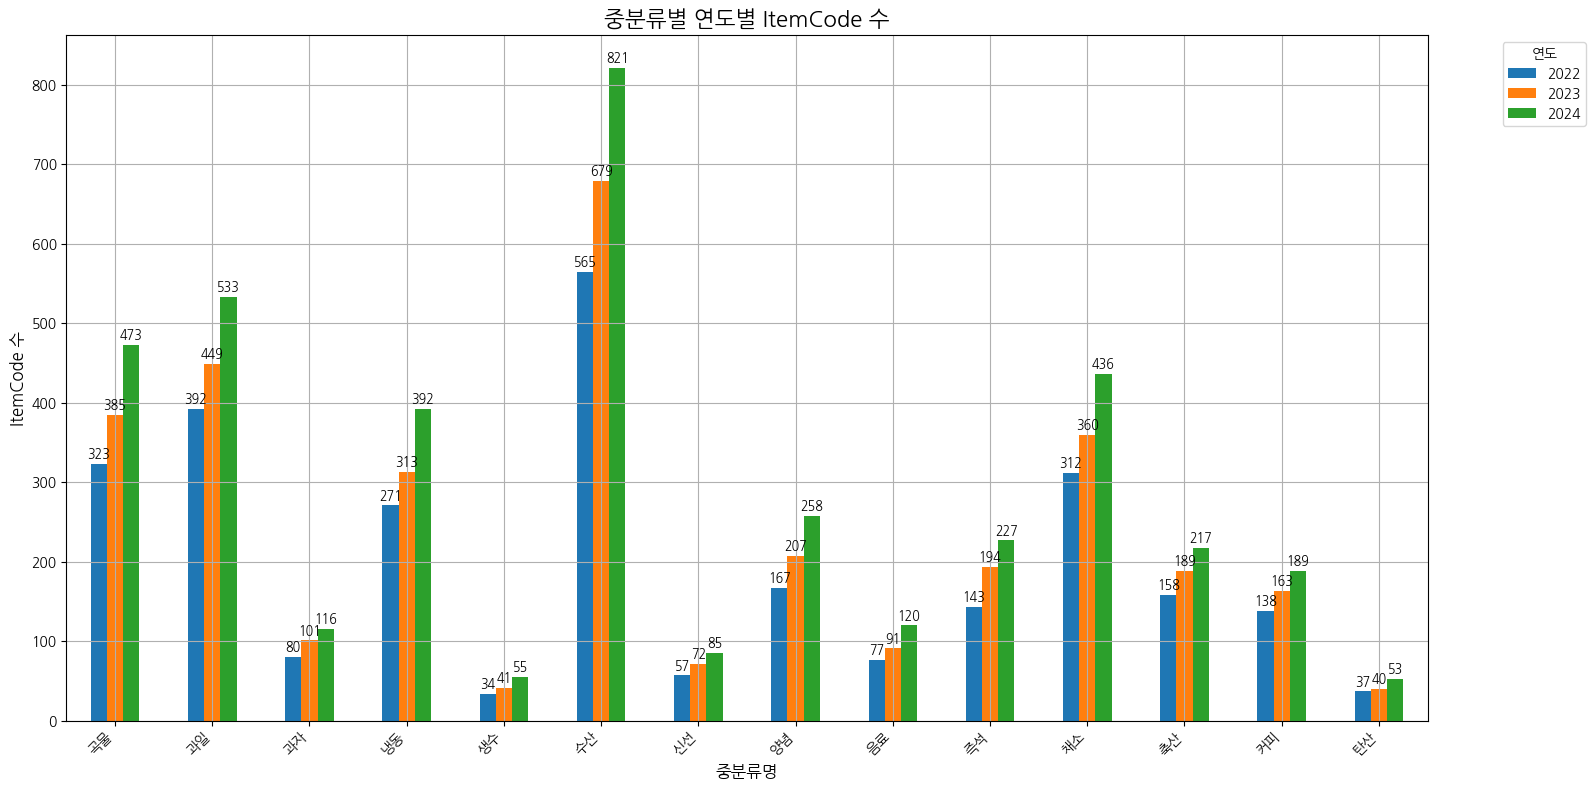

In [62]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (맑은 고딕이 없는 경우 자동 설정 제외)
plt.rcParams['font.family'] = 'NanumGothic'  # macOS 사용자
plt.rcParams['axes.unicode_minus'] = False

# 막대그래프 그리기
ax = pivot_df.plot(kind='bar', figsize=(16, 8))
plt.title("중분류별 연도별 ItemCode 수", fontsize=16)
plt.xlabel("중분류명", fontsize=12)
plt.ylabel("ItemCode 수", fontsize=12)
plt.legend(title="연도", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# 수치 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()


### 수산과일채소만

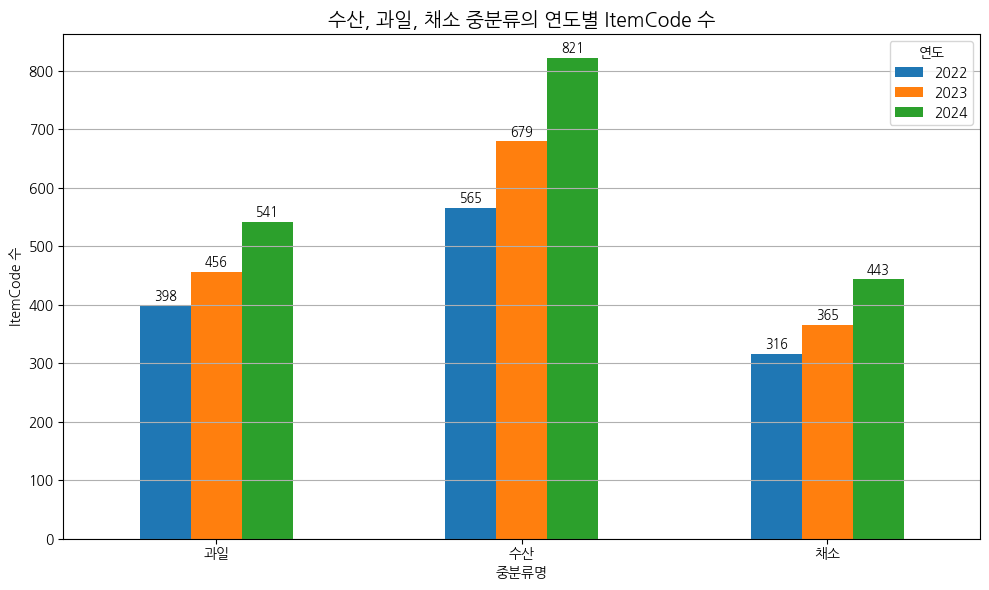

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
items_df = pd.read_csv("on_items.csv", encoding='cp949')
items_df['Year'] = items_df['PriceYear']

# 중분류-연도별 고유 ItemCode 수 집계
itemcode_count = (
    items_df.groupby(['ItemMiddleName', 'Year'])['ItemCode']
    .nunique()
    .reset_index()
    .rename(columns={'ItemCode': 'ItemCodeCount'})
)

# 수산, 과일, 채소만 필터링
selected = itemcode_count[itemcode_count['ItemMiddleName'].isin(['수산', '과일', '채소'])]

# 피벗 테이블 생성
pivot_selected = selected.pivot(index='ItemMiddleName', columns='Year', values='ItemCodeCount').fillna(0)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # macOS
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False

# 막대그래프 그리기
ax = pivot_selected.plot(kind='bar', figsize=(10, 6))
plt.title("수산, 과일, 채소 중분류의 연도별 ItemCode 수", fontsize=14)
plt.xlabel("중분류명")
plt.ylabel("ItemCode 수")
plt.legend(title="연도")
plt.xticks(rotation=0)  # <-- 여기! 레이블을 가로로 표시
plt.grid(True, axis='y')

# 수치 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()
